In [4]:
#@title 1.3. IMPORT LIBRARY

import sys
sys.path.append('../utils')
from data_retrieval import data_retrieval
from neural_net import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
df = data_retrieval()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,Risk
0,2.766456,0.146949,-0.745131,-1.236478,0.176948,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,-1.191404,0.146949,0.949817,2.248194,-0.284901,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,1.183312,-1.383771,-0.416562,-0.738668,0.045495,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.831502,0.146949,1.634247,1.750384,0.130233,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,1.535122,0.146949,0.566664,0.256953,0.229637,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


checkpoint directory created: ./model
saving model version 0.0


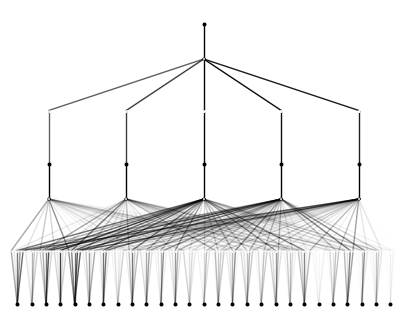

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = df_train.drop(columns='Risk'), df_train['Risk']
X_test, y_test = df_test.drop(columns='Risk'), df_test['Risk']

dataset = dict()
dataset['train_input'] = torch.tensor(X_train.values)
dataset['train_label'] = torch.tensor(y_train.values)
dataset['test_input'] = torch.tensor(X_test.values)
dataset['test_label'] = torch.tensor(y_test.values)

model = KAN(width=[27,5,1], grid=3, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [15]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)

| train_loss: 4.59e-01 | test_loss: 4.56e-01 | reg: 1.28e+00 | : 100%|█| 50/50 [00:21<00:00,  2.37it


saving model version 0.1


{'train_loss': [array(0.45885846),
  array(0.45880262),
  array(0.45880171),
  array(0.45880188),
  array(0.45880276),
  array(0.4588012),
  array(0.45880115),
  array(0.45880125),
  array(0.45880183),
  array(0.45880179),
  array(0.45880109),
  array(0.45880111),
  array(0.4588011),
  array(0.45880109),
  array(0.45880109),
  array(0.4588011),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  array(0.45880109),
  

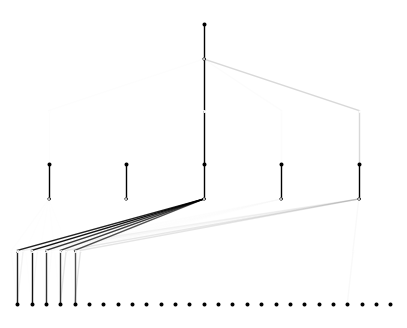

In [16]:
model.plot()

saving model version 0.2


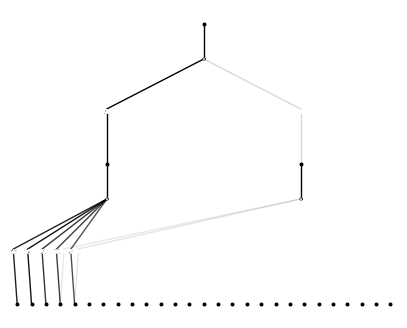

In [17]:
model = model.prune()
model.plot()

In [18]:
model = model.refine(10)

saving model version 0.3


In [19]:
model.fit(dataset, opt="LBFGS", steps=50)

| train_loss: 4.59e-01 | test_loss: 4.57e-01 | reg: 3.14e-01 | : 100%|█| 50/50 [00:11<00:00,  4.29it

saving model version 0.4


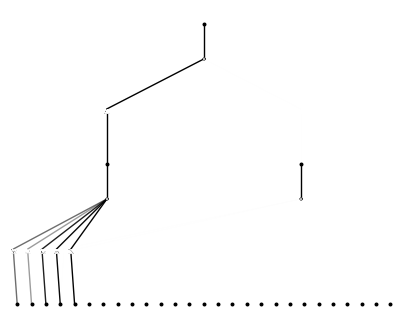

In [20]:
model.plot()

In [23]:
model(dataset['train_input'])

tensor([[0.6988],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0.6988],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6987],
        [0.6988],
        [0.6988],
        [0.6987],
        [0

In [30]:
pred = (model(dataset['test_input']).detach().cpu().resolve_conj().resolve_neg().numpy().flatten() >= 0.5).astype(int)
np.mean(pred == y_test)

0.71